# Corpus analysis

Here a corpus analysis is conducted. The chord progression of several pieces of a corpus has been evaluated by a model so that each pieces has a set of ground truth chords and a set of estimated chords. Each pair of chords are here compared using the different metrics.

In [1]:
import math
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from glob import glob
from fractions import Fraction
from scipy import stats

import sys
sys.path.append('../python_scripts')

from metric import get_distance
from data_types import ChordType, PitchType
from constants import TRIAD_REDUCTION

In [2]:
corpus_df = pd.read_csv('../Data/corpus.csv')
corpus_df['sps_accuracy'] = corpus_df['average_sps'].apply(lambda sps :1-sps)
corpus_df['vl_accuracy'] = corpus_df['average_vl'].apply(lambda vl :1-vl)
corpus_df['tbt_accuracy'] = corpus_df['average_tbt'].apply(lambda tbt :1-tbt)

### Visualization of the average accuracy using the different metrics for each pieces


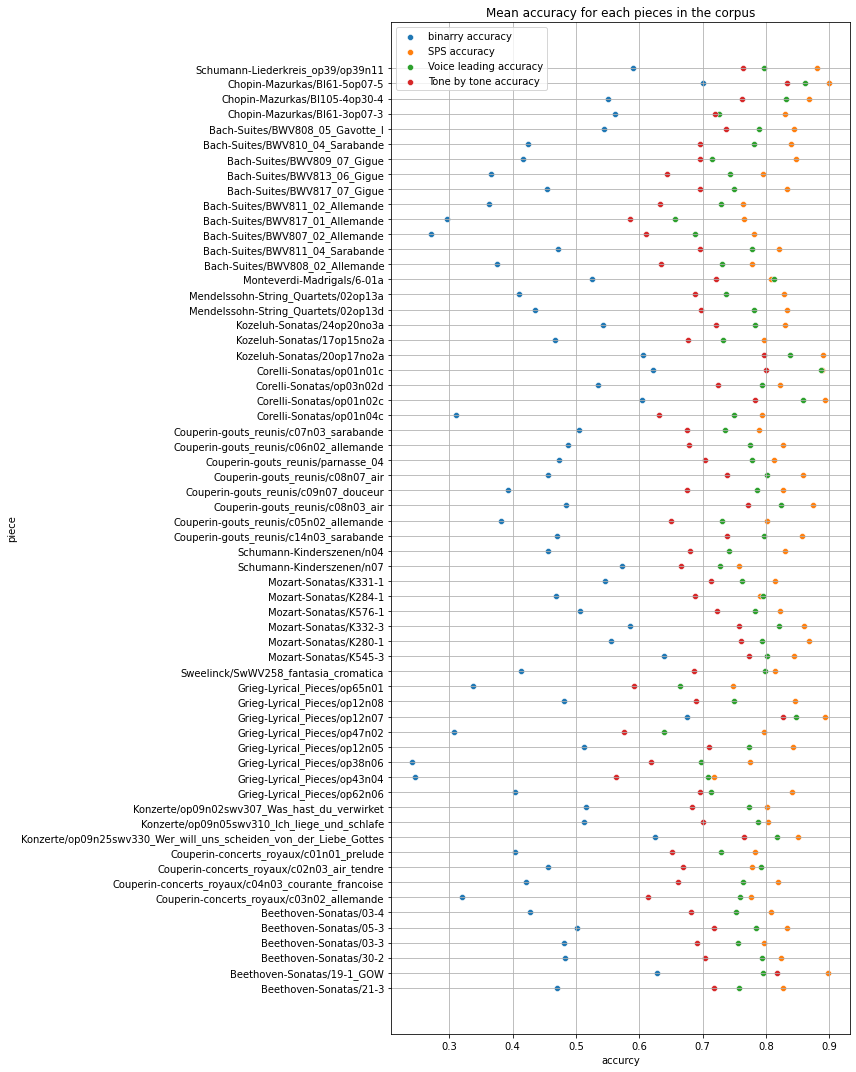

In [3]:
# Visualization of the average accuracy using the different metrics for each pieces

fig, ax = plt.subplots(1,1, figsize=(12,15))

sns.scatterplot(data=corpus_df, x='binary_accuracy', y='name', label='binarry accuracy', marker='o', ax=ax)
sns.scatterplot(data=corpus_df, x='sps_accuracy', y='name', label='SPS accuracy', marker='o', ax=ax)
sns.scatterplot(data=corpus_df, x='vl_accuracy', y='name', label='Voice leading accuracy', marker='o', ax=ax)
sns.scatterplot(data=corpus_df, x='tbt_accuracy', y='name', label='Tone by tone accuracy', marker='o', ax=ax)
ax.set(title='Mean accuracy for each pieces in the corpus', xlabel='accurcy', ylabel='piece')
ax.grid()
ax.legend()
fig.tight_layout()

### Visualization of the average metric accuracy against each other 


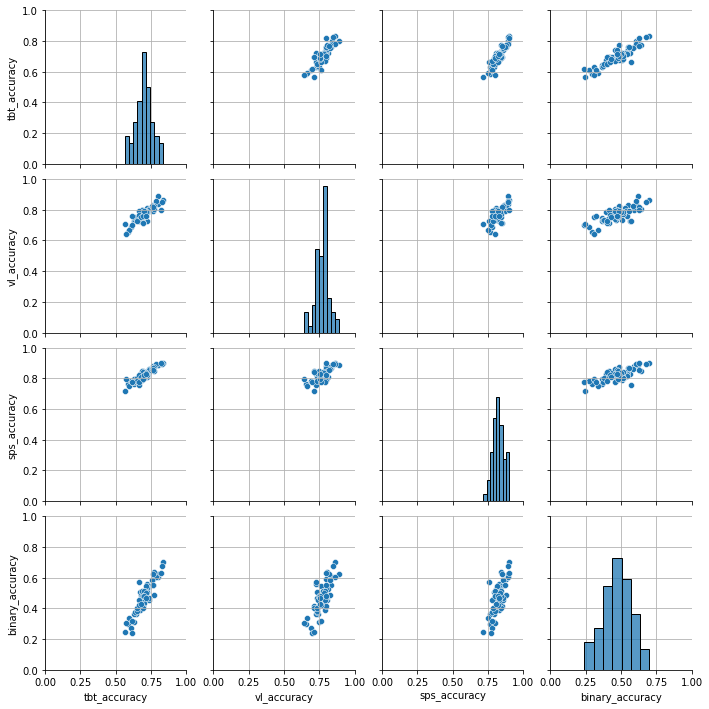

In [4]:
# Visualization of the average metric accuracy against each other 

g = sns.PairGrid(corpus_df[['tbt_accuracy','vl_accuracy','sps_accuracy','binary_accuracy']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.set(ylim=(0,1), xlim=(0,1))
for i in range(4):
    for j in range(4):
        g.axes[i,j].grid()

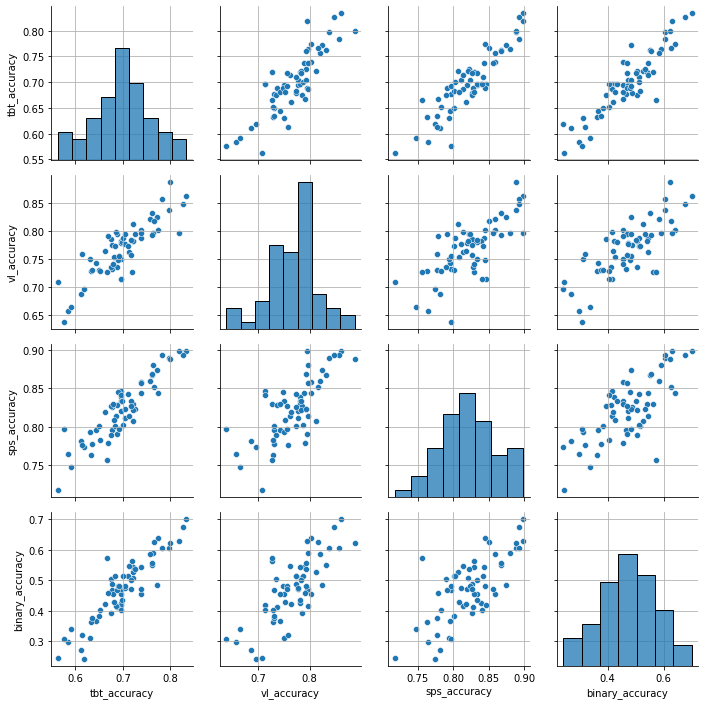

In [5]:
# Visualization of the average metric accuracy against each other 

g = sns.PairGrid(corpus_df[['tbt_accuracy','vl_accuracy','sps_accuracy','binary_accuracy']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
for i in range(4):
    for j in range(4):
        g.axes[i,j].grid()

### Correclation between each average metric accuracy


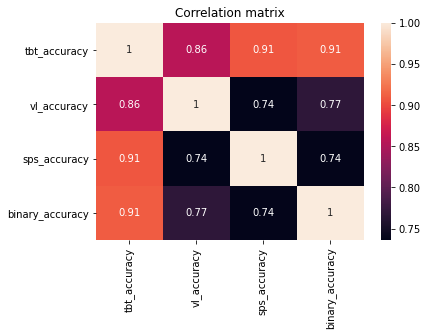

In [6]:
# Visualization of the correclation between each average metric accuracy

corr_matrix = corpus_df[['tbt_accuracy','vl_accuracy','sps_accuracy','binary_accuracy']].corr()

ax = sns.heatmap(corr_matrix, annot=True)
ax.set(title='Correlation matrix', xlabel='', ylabel='')

fig.tight_layout()

___

## Linear regressions

Here one looks at the linear relationship that could stands out between the different metrics results.

In [7]:
accuracies = pd.DataFrame({'name':[name for name in corpus_df.name]*3})
accuracies['metric_accuracy'] = pd.concat([pd.concat([corpus_df['sps_accuracy'],corpus_df['vl_accuracy']],ignore_index=True),
                                            corpus_df['tbt_accuracy']],ignore_index=True)
accuracies['binary_accuracy'] = [accuracy for accuracy in corpus_df.binary_accuracy]*3
accuracies['metric'] = pd.Series(['SPS']*len(corpus_df) +['voice leading']*len(corpus_df)+['tone by tone']*len(corpus_df))

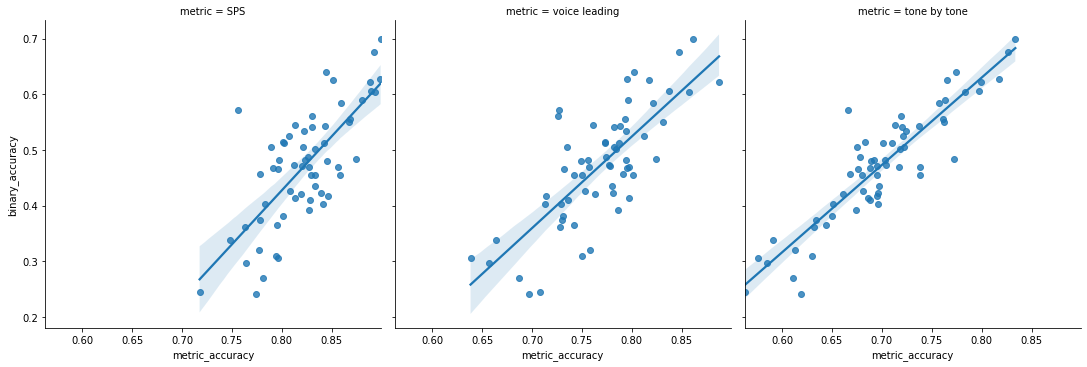

In [8]:
g = sns.lmplot(data=accuracies, x='metric_accuracy', y='binary_accuracy', col='metric')
#ax.set(title='Voice leading accuracy vs. tone by tone',xlabel='Tone by tone accurcy', ylabel='Voice leading accurcy')


In [9]:
mod = smf.ols(formula='binary_accuracy ~ sps_accuracy',
              data=corpus_df)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        binary_accuracy   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     71.85
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           7.57e-12
Time:                        18:09:28   Log-Likelihood:                 77.115
No. Observations:                  62   AIC:                            -150.2
Df Residuals:                      60   BIC:                            -146.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1256      0.189     -5.965   

___
___

# Study of an outlier

Here we go into the details of why a particular piece stands out as an outlier.

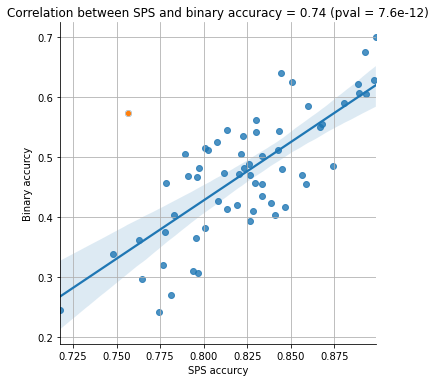

In [10]:
outlier_sps = corpus_df.sps_accuracy.nsmallest(3).iloc[2]
outlier = corpus_df.query('sps_accuracy == @outlier_sps').name.iloc[0]
corr_sps_b = stats.pearsonr(corpus_df['sps_accuracy'],corpus_df['binary_accuracy'])

ax = sns.lmplot(data=corpus_df, x='sps_accuracy', y='binary_accuracy')
sns.scatterplot(data=corpus_df.query('sps_accuracy == @outlier_sps'), x='sps_accuracy', y='binary_accuracy',
                marker='o')

ax.set(title='Correlation between SPS and binary accuracy = {:.2} (pval = {:.2g})'.format(corr_sps_b[0], corr_sps_b[1]),
        xlabel='SPS accurcy', ylabel='Binary accurcy')
plt.grid()
fig.tight_layout()

In [11]:
outlier

'Schumann-Kinderszenen/n07'

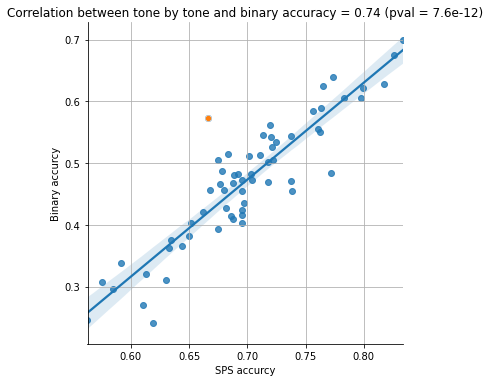

In [12]:
corr_tbt_b = stats.pearsonr(corpus_df['tbt_accuracy'],corpus_df['binary_accuracy'])

ax = sns.lmplot(data=corpus_df, x='tbt_accuracy', y='binary_accuracy')
sns.scatterplot(data=corpus_df.query('name == @outlier'), x='tbt_accuracy', y='binary_accuracy',
                marker='o')

ax.set(title='Correlation between tone by tone and binary accuracy = {:.2} (pval = {:.2g})'.format(corr_sps_b[0], corr_sps_b[1]),
        xlabel='SPS accurcy', ylabel='Binary accurcy')
plt.grid()
fig.tight_layout()

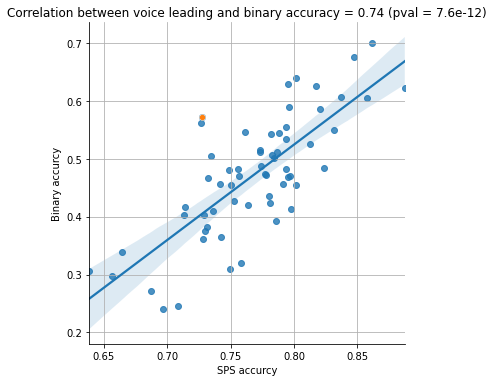

In [13]:
corr_vl_b = stats.pearsonr(corpus_df['vl_accuracy'],corpus_df['binary_accuracy'])

ax = sns.lmplot(data=corpus_df, x='vl_accuracy', y='binary_accuracy')
sns.scatterplot(data=corpus_df.query('name == @outlier'), x='vl_accuracy', y='binary_accuracy',
                marker='o')

ax.set(title='Correlation between voice leading and binary accuracy = {:.2} (pval = {:.2g})'.format(corr_sps_b[0], corr_sps_b[1]),
        xlabel='SPS accurcy', ylabel='Binary accurcy')
plt.grid()
fig.tight_layout()

In [14]:
path_outlier = '../Data/output_sps_kse-100/' + outlier + '_results.tsv'

SKn7_df = pd.read_csv(path_outlier,
                      sep='\t', index_col=0, converters={'duration': Fraction})

SKn7_df['gt_chord_type'] = SKn7_df['gt_chord_type'].apply(lambda r : ChordType[r.split(".")[1]])
SKn7_df['est_chord_type'] = SKn7_df['est_chord_type'].apply(lambda r : ChordType[r.split(".")[1]])    

# SPS metric
SKn7_df['sps_distance'] = SKn7_df.apply(lambda r : get_distance(distance='SPS',
                                                                 root1=r.gt_chord_root,
                                                                 root2=r.est_chord_root,
                                                                 chord_type1=r.gt_chord_type,
                                                                 chord_type2=r.est_chord_type,
                                                                 inversion1=r.gt_chord_inv,
                                                                 inversion2=r.est_chord_inv
                                                                ), axis=1)

SKn7_df['sps_accuracy'] = SKn7_df['sps_distance'].apply(lambda sps :1-sps)

# Voice leading metric
SKn7_df['vl_distance'] = SKn7_df.apply(lambda r : get_distance(distance='voice leading',
                                                                 root1=r.gt_chord_root,
                                                                 root2=r.est_chord_root,
                                                                 chord_type1=r.gt_chord_type,
                                                                 chord_type2=r.est_chord_type,
                                                                 inversion1=r.gt_chord_inv,
                                                                 inversion2=r.est_chord_inv,
                                                               bass_weight=3
                                                                ), axis=1)

SKn7_df['vl_distance'] = SKn7_df['vl_distance'].apply(lambda r : r/max(SKn7_df['vl_distance']))
SKn7_df['vl_accuracy'] = SKn7_df['vl_distance'].apply(lambda vl :1-vl)

# Tone by tone metric
SKn7_df['tbt_distance'] = SKn7_df.apply(lambda r : get_distance(distance='tone by tone',
                                                                 root1=r.gt_chord_root,
                                                                 root2=r.est_chord_root,
                                                                 chord_type1=r.gt_chord_type,
                                                                 chord_type2=r.est_chord_type,
                                                                 inversion1=r.gt_chord_inv,
                                                                 inversion2=r.est_chord_inv,
                                                                bass_weight=3,
                                                                root_weight=3
                                                                ), axis=1)

SKn7_df['tbt_accuracy'] = SKn7_df['tbt_distance'].apply(lambda tbt :1-tbt)

In [15]:
false_est_df = SKn7_df.query('full_correct == False')

durations = false_est_df.groupby(['gt_chord', 'est_chord']).duration.sum().unstack().astype(float, copy=False)

# SPS metric
SPS_false_est_df = false_est_df[['gt_chord', 'est_chord','sps_accuracy']].drop_duplicates()
SPS_false_est_df = SPS_false_est_df.pivot(index='gt_chord', columns='est_chord', values='sps_accuracy')

# Voice leading metric
vl_false_est_df = false_est_df[['gt_chord', 'est_chord','vl_accuracy']].drop_duplicates()
vl_false_est_df = vl_false_est_df.pivot(index='gt_chord', columns='est_chord', values='vl_accuracy')

# Tone by tone metric
tbt_false_est_df = false_est_df[['gt_chord', 'est_chord','tbt_accuracy']].drop_duplicates()
tbt_false_est_df = tbt_false_est_df.pivot(index='gt_chord', columns='est_chord', values='tbt_accuracy')

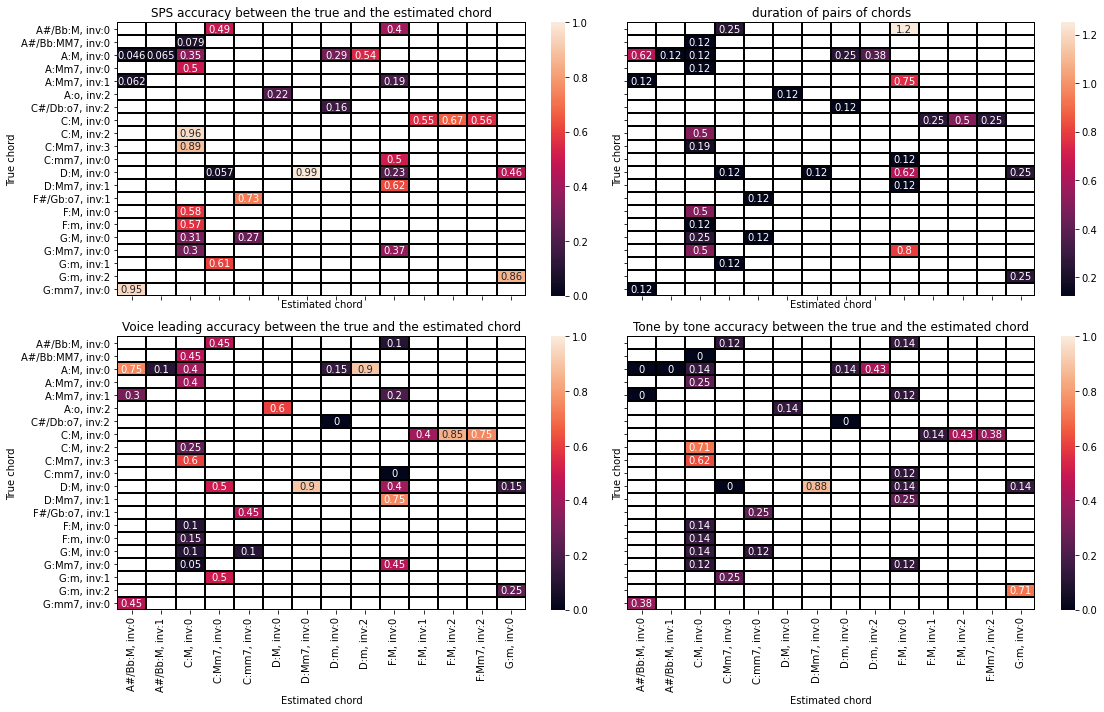

In [16]:
fig, axs = plt.subplots(2,2,figsize = (16,10), sharey=True, sharex=True)

sns.heatmap(SPS_false_est_df, annot=True, vmin = 0, vmax = 1, ax = axs[0,0],
            linecolor = 'black', linewidths = 0.005)
axs[0,0].set(title='SPS accuracy between the true and the estimated chord', xlabel='Estimated chord', ylabel='True chord')

sns.heatmap(durations, annot = True, ax = axs[0,1], linecolor='black', linewidths = 0.005)
axs[0,1].set(title='duration of pairs of chords', xlabel='Estimated chord', ylabel='True chord')

sns.heatmap(vl_false_est_df, annot=True, vmin = 0, vmax = 1, ax = axs[1,0],
            linecolor = 'black', linewidths = 0.005)
axs[1,0].set(title='Voice leading accuracy between the true and the estimated chord', xlabel='Estimated chord', ylabel='True chord')

sns.heatmap(tbt_false_est_df, annot=True, vmin = 0, vmax = 1, ax = axs[1,1],
            linecolor = 'black', linewidths = 0.005)
axs[1,1].set(title='Tone by tone accuracy between the true and the estimated chord', xlabel='Estimated chord', ylabel='True chord')

fig.tight_layout()